In [1]:
from pandas_plink import read_plink
import numpy as np
import pandas as pd
from collections import OrderedDict as odict
from math import isnan
from scipy.stats import chi2_contingency
import timeit
import multiprocessing as mp
import os
import psutil
import pickle
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

In [2]:
class pre_processing:
    def __init__(self, plink_fn, pheno_fn):
        self.pheno = self.read_pheno(pheno_fn)
        self.bim,self.fam,self.bed = read_plink(plink_fn)
        self.cases_i,self.controls_i = self.cases_controls()
        self.nbant = nbant
        self.nbt = nbt
        self.evaporation_rate = evaporation_rate
        self.init_val = init_val
        self.total_fitness_evals = total_fitness_evals
        
        
    
    def run(self):
        return self.bim, self.fam, self.bed, self.cases_i, self.controls_i
        
    def cases_controls(self):
        cases_i = []
        controls_i =[]
        for index,rows in self.fam.iterrows():
            df = self.pheno.loc[self.pheno["FID"] == rows["fid"]]
            t2d = df.iat[0,4]
            if(t2d == '1'):
                cases_i.append(index)
            elif(t2d == '0'):
                controls_i.append(index) 
        return cases_i, controls_i
    

    def read_pheno(self,fn):
        header = odict(
            [
                ("FID", str),
                ("IID", str),
                ("AGE", str),
                ("BMI", str),
                ("T2D", str),
            ]
        )

        df = pd.read_csv(
            fn,
            delim_whitespace=True,
            header=None,
            names=header.keys(),
            dtype=header,
            compression=None,
            engine="c",
        )
        df["i"] = range(df.shape[0])
        return df
    
    
    

In [3]:
class aco_gwas:
    def __init__(self, bim, fam, bed, cases_i, controls_i, nbant, nbt, evaporation_rate, init_val, total_fitness_evals):
        
        #Coppying the bim, bed and fam files
        self.bim = bim
        self.bed = bed
        self.fam = fam
        self.cases_i = cases_i
        self.controls_i = controls_i
        
        
        #Calculating the number of individuals and snps in the dataset
        self.n_individuals = self.fam.shape[0]
        self.n_snps = self.bim.shape[0]
        
        #Calculating the number of cases and controls
        self.n_cases = len(self.cases_i)
        self.n_controls = len(self.controls_i)
        
        #ACO setup
        self.nbant = nbant
        self.nbt = nbt
        self.init_val = init_val
        self.pheromone_mat = np.zeros(self.n_snps)
        self.evaporation_rate = evaporation_rate
        self.total_fitness_evals = total_fitness_evals
        self.numgen = total_fitness_evals/nbant
        self.best_p = 1
        self.best_stat = 0
        self.best_snp = []
        self.best_fitness = 0
        self.best_fitness_graph = []
    
    def init_pheromone(self, init_val):
        self.pheromone_mat.fill(init_val)
    
    def tournament_choice(self):
        tournament = np.random.randint(self.n_snps, size = nbt)
        biggest = 0
        biggest_i = 0
        for i in tournament:
            if(self.pheromone_mat[i] > biggest):
                biggest = self.pheromone_mat[i]
                biggest_i = i
        return biggest_i
                
            
    def chi_sq_omnibus(self, snp1, snp2):
        snp1_mat = self.bed[snp1].compute()
        snp2_mat = self.bed[snp2].compute()
        
        t_cases = np.zeros((4,4))
        t_controls = np.zeros((4,4))
        table_i = []
        table_j = []
        
        for i in self.cases_i:
            if(isnan(snp1_mat[i])):
                snp1_mat[i] = 3
                
            if(isnan(snp2_mat[i])):
                snp2_mat[i] = 3  
                
            t_cases[int(snp1_mat[i])][int(snp2_mat[i])] += 1
            
            
        for i in self.controls_i:
            
            if(isnan(snp1_mat[i])):
                snp1_mat[i] = 3
                
            if(isnan(snp2_mat[i])):
                snp2_mat[i] = 3
                
            t_controls[int(snp1_mat[i])][int(snp2_mat[i])] += 1
            
        
        table_i = t_cases[:3,:3]
        table_i = table_i.flatten()
        non_zeros = np.nonzero(table_i)
        table_i = table_i[non_zeros]
        
        table_j = t_controls[:3,:3]
        table_j = table_j.flatten()
        table_j = table_j[non_zeros]
        
        table = [table_i, table_j]
        stat, p, dof, expected = chi2_contingency(table)
        
        return stat, p 
    
    def update_pheromone(self, snp1, snp2):
        chi_sq_val, p_val = self.chi_sq_omnibus(snp1,snp2)
        if(p_val < self.best_p):
            self.best_stat = chi_sq_val
            self.best_p = p_val
            self.best_snp = [snp1,snp2]
        self.pheromone_mat[int(snp1)] += chi_sq_val
        self.pheromone_mat[int(snp2)] += chi_sq_val
        
        
    def evaporate_pheromone(self):
        self.pheromone_mat *= self.evaporation_rate
        
        
    def ant(self):
        snp1 = self.tournament_choice()
        snp2 = self.tournament_choice()
        self.update_pheromone(snp1,snp2)
        
    
    def run(self):
        self.init_pheromone(self.init_val)
        
        for i in range(int(self.numgen)):
            for j in range(nbant):
                self.ant()  
            if(np.max(self.pheromone_mat) > self.best_fitness):
                self.best_fitness = np.max(self.pheromone_mat)
            self.best_fitness_graph.append(self.best_fitness)
            
            
            self.evaporate_pheromone()
            print("Generation: ", i," Lowest P-val:", self.best_p)

        
        return self.pheromone_mat,self.best_fitness, self.best_p        

In [10]:
class post_processing:
    def __init__(self,bim, fam):
        self.bim = bim
        self.fam = fam
    
    def save_file(self, fn, val):
        fileObject = open(fn,'wb')
        pickle.dump(val,fileObject)   
        fileObject.close()

    
    def load_file(self, fn):
        fileObject = open(fn,'rb')
        val = pickle.load(fileObject)
        fileObject.close()
        return val
    
    def best_snps(self, n_best_snps, p_values):
        top_snps = np.argsort(p_values)[:n_best_snps]
        for i in top_snps:
            print("SNP: ", bim.loc[i, 'snp'], "P-value: ", p_values[i])
    
    def manhatten_plot(self, pvalues,fn):
        self.bim['minuslog10pvalue'] = -np.log10(pvalues)
        m_plot = self.bim[['i','chrom','minuslog10pvalue' ]]
        df_grouped = m_plot.groupby(('chrom'))
        plt.style.use('ggplot')
        fig = plt.figure(dpi = 300)
        ax = fig.add_subplot(111)
        colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
        x_labels = []
        x_labels_pos = []

        for num, (name, group) in enumerate(df_grouped):
            group.plot(kind='scatter', x='i', y='minuslog10pvalue',color=colors[num % len(colors)], ax=ax, s = 10000000/len(bim))
            x_labels.append(name)
            x_labels_pos.append((group['i'].iloc[-1] - (group['i'].iloc[-1] - group['i'].iloc[0])/2))
        ax.set_xticks(x_labels_pos)
        ax.set_xticklabels(x_labels)
        ax.set_xlim([0, len(m_plot)])
        ax.set_ylim([0, 30])
        ax.set_xlabel('Chromosome')
        plt.xticks(fontsize=6, rotation=60)
        plt.yticks(fontsize=6)
        plt.savefig(fn, bbox_inches='tight')        

In [11]:
plink_fn = '/Users/raouldias/Desktop/Extend/extend_csp_data_annon'
pheno_fn = '/Users/raouldias/Desktop/Extend/extend_phenotype.txt'
nbant = 200
nbt = 1000
evaporation_rate = 0.99
init_val = 1
total_fitness_evals = 1000000

bim, fam, bed, cases_i, controls_i = pre_processing(plink_fn, pheno_fn).run()
aco = aco_gwas(bim, fam, bed, cases_i, controls_i, nbant, nbt, evaporation_rate, init_val, total_fitness_evals)



Mapping files: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


In [12]:
fn = '/Users/raouldias/Desktop/Extend/GSA-rs34872471Tabu'
post = post_processing(bim,fam)
p_vals = post.load_file(fn)

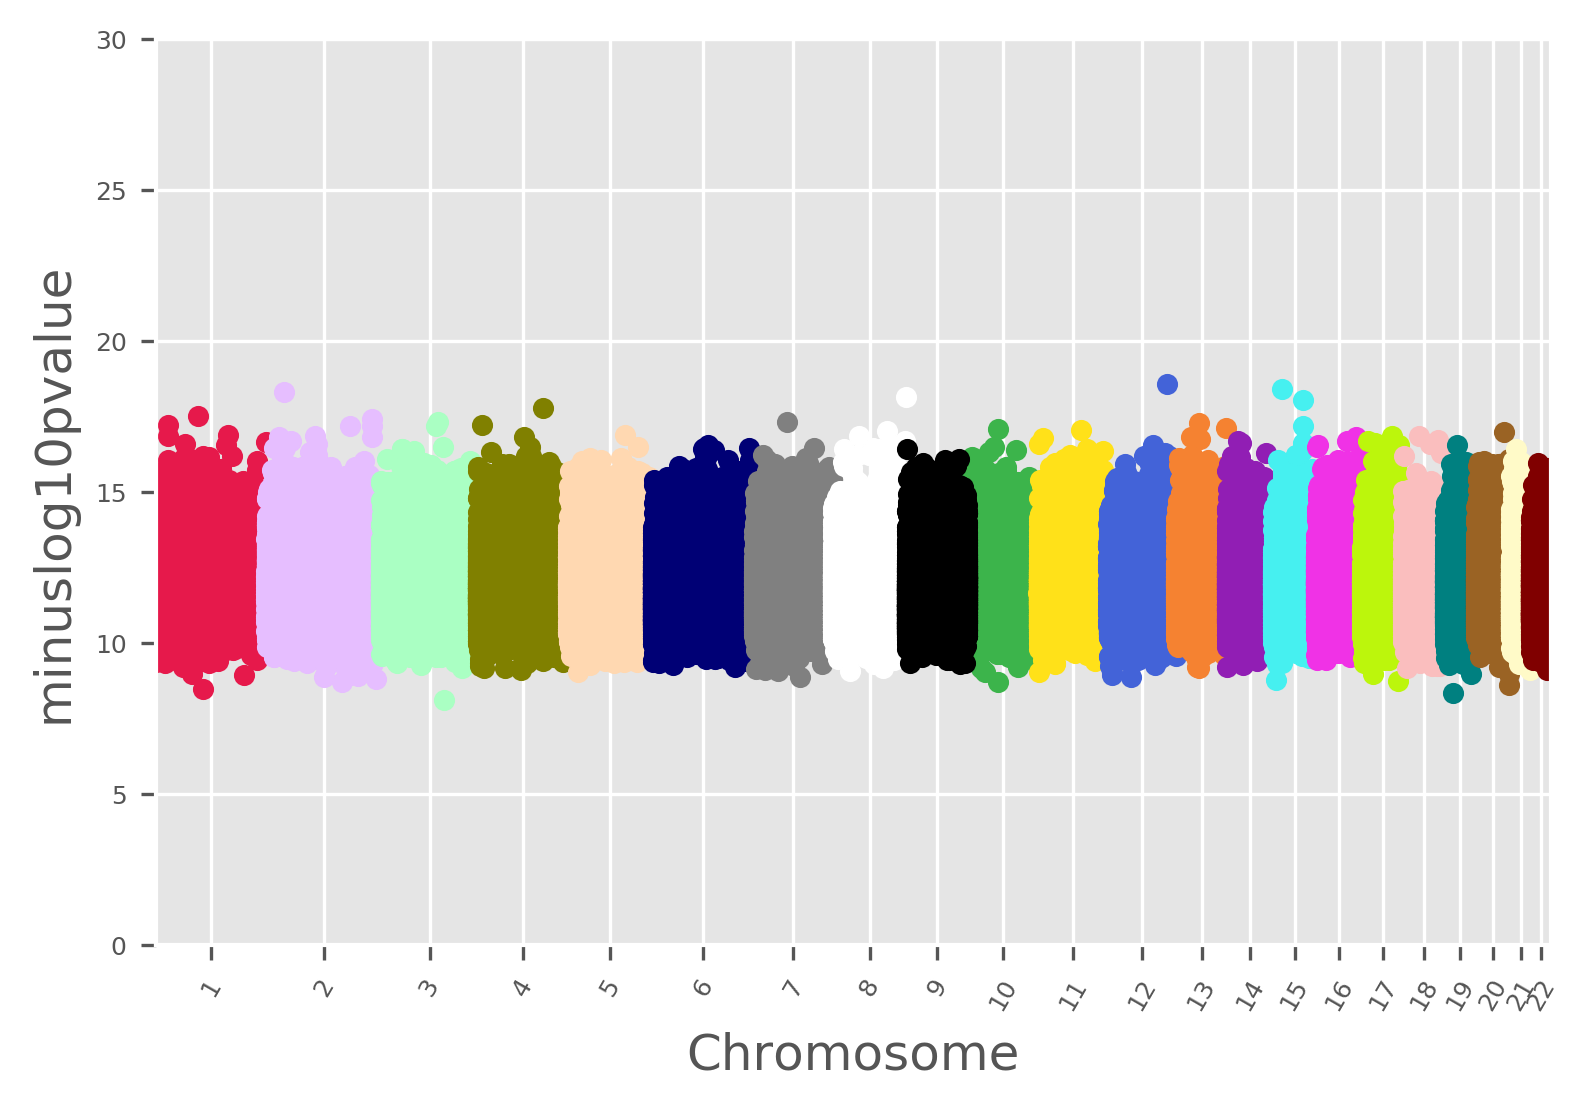

In [13]:
post.manhatten_plot(p_vals, 'mahatten_2_electric_boogaloo')

In [6]:
pheromone_matrix, best_fitness, best_p = aco.run()

Generation:  0  Lowest P-val: 0.0005326108778490816
Generation:  1  Lowest P-val: 0.0005326108778490816
Generation:  2  Lowest P-val: 0.00040255342168826384
Generation:  3  Lowest P-val: 0.00040255342168826384
Generation:  4  Lowest P-val: 8.60745279301011e-06
Generation:  5  Lowest P-val: 8.60745279301011e-06
Generation:  6  Lowest P-val: 8.60745279301011e-06
Generation:  7  Lowest P-val: 8.60745279301011e-06
Generation:  8  Lowest P-val: 8.60745279301011e-06
Generation:  9  Lowest P-val: 8.60745279301011e-06
Generation:  10  Lowest P-val: 8.60745279301011e-06
Generation:  11  Lowest P-val: 8.60745279301011e-06
Generation:  12  Lowest P-val: 8.60745279301011e-06
Generation:  13  Lowest P-val: 8.60745279301011e-06
Generation:  14  Lowest P-val: 8.60745279301011e-06
Generation:  15  Lowest P-val: 8.60745279301011e-06
Generation:  16  Lowest P-val: 8.60745279301011e-06
Generation:  17  Lowest P-val: 8.60745279301011e-06
Generation:  18  Lowest P-val: 8.60745279301011e-06
Generation:  19 

Generation:  153  Lowest P-val: 2.5941714292443238e-06
Generation:  154  Lowest P-val: 2.5941714292443238e-06
Generation:  155  Lowest P-val: 2.5941714292443238e-06
Generation:  156  Lowest P-val: 2.5941714292443238e-06
Generation:  157  Lowest P-val: 2.5941714292443238e-06
Generation:  158  Lowest P-val: 2.5941714292443238e-06
Generation:  159  Lowest P-val: 2.5941714292443238e-06
Generation:  160  Lowest P-val: 2.5941714292443238e-06
Generation:  161  Lowest P-val: 2.5941714292443238e-06
Generation:  162  Lowest P-val: 2.5941714292443238e-06
Generation:  163  Lowest P-val: 2.5941714292443238e-06
Generation:  164  Lowest P-val: 2.5941714292443238e-06
Generation:  165  Lowest P-val: 2.5941714292443238e-06
Generation:  166  Lowest P-val: 2.5941714292443238e-06
Generation:  167  Lowest P-val: 2.5941714292443238e-06
Generation:  168  Lowest P-val: 1.31250579254538e-07
Generation:  169  Lowest P-val: 1.31250579254538e-07
Generation:  170  Lowest P-val: 1.31250579254538e-07
Generation:  171

Generation:  303  Lowest P-val: 6.7563506566299935e-12
Generation:  304  Lowest P-val: 6.7563506566299935e-12
Generation:  305  Lowest P-val: 6.7563506566299935e-12
Generation:  306  Lowest P-val: 6.7563506566299935e-12
Generation:  307  Lowest P-val: 6.7563506566299935e-12
Generation:  308  Lowest P-val: 6.7563506566299935e-12
Generation:  309  Lowest P-val: 6.7563506566299935e-12
Generation:  310  Lowest P-val: 6.7563506566299935e-12
Generation:  311  Lowest P-val: 6.7563506566299935e-12
Generation:  312  Lowest P-val: 6.7563506566299935e-12
Generation:  313  Lowest P-val: 6.7563506566299935e-12
Generation:  314  Lowest P-val: 6.7563506566299935e-12
Generation:  315  Lowest P-val: 6.7563506566299935e-12
Generation:  316  Lowest P-val: 6.7563506566299935e-12
Generation:  317  Lowest P-val: 6.7563506566299935e-12
Generation:  318  Lowest P-val: 6.7563506566299935e-12
Generation:  319  Lowest P-val: 6.7563506566299935e-12
Generation:  320  Lowest P-val: 6.7563506566299935e-12


KeyboardInterrupt: 